In [1]:
%load_ext autoreload
%autoreload 2

import astropy
import galsim
import matplotlib.pyplot as plt
import numpy as np
import scarlet
import sep

import btk

In [2]:
COSMOS_CATALOG_PATHS = [
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2.fits",
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2_fits.fits",
]


stamp_size = 11
max_number = 1
batch_size = 10
max_shift = 0
catalog = btk.catalog.CosmosCatalog.from_file(COSMOS_CATALOG_PATHS)
survey = btk.survey.get_surveys("LSST")
seed=31

import galsim 
galsim_catalog = galsim.COSMOSCatalog(COSMOS_CATALOG_PATHS[0], exclusion_level="marginal")

sampling_function = btk.sampling_functions.DefaultSampling(max_number=max_number, maxshift=max_shift, stamp_size=stamp_size, seed=seed)

draw_generator = btk.draw_blends.CosmosGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all",
    verbose=False,
    gal_type="parametric",
    seed=seed,
)

In [3]:
blend = next(draw_generator)


Generating blends for LSST survey:   0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
field_images = blend["blend_images"]
isolated_images = blend["isolated_images"]

# Use Scarlet

In [5]:
psf = np.array([p.drawImage(galsim.Image(field_images[0].shape[1],field_images[0].shape[2]),scale=survey.pixel_scale.to_value("arcsec")).array for p in blend["psf"]])
bands=[f for f in survey._filters]
wcs = blend["wcs"]

In [6]:
import scarlet.psf
from scarlet.psf import ImagePSF

In [7]:
def predict_with_scarlet(image, x_pos, y_pos, show_scene, show_sources, filters):
    sig = []
    weights = np.ones_like(image)
    for i in range(6):
        sig.append(sep.Background(image[i]).globalrms)
        weights[i] = weights[i] / (sig[i]**2)
    observation = scarlet.Observation(
            image, psf=scarlet.psf.ImagePSF(psf), weights= weights, channels=bands, wcs=wcs
        )
    
    model_psf = scarlet.GaussianPSF(sigma=(0.8,) * len(filters))
    model_frame = scarlet.Frame(
    image.shape,
    psf=model_psf,
    channels=filters, wcs=wcs)

    
    observation = observation.match(model_frame)
    sources = []
    for i in range(len(x_pos)):
        result = scarlet.ExtendedSource(
            model_frame,
            model_frame.get_sky_coord((x_pos[i], y_pos[i])),
            observation,
            thresh=1,
            shifting=True,
        )
        sources.append(result)

    scarlet.initialization.set_spectra_to_match(sources, observation)
    
    scarlet_blend = scarlet.Blend(sources, observation)
    
    %time it, logL = scarlet_blend.fit(200, e_rel=1e-5)
    #print(f"scarlet ran for {it} iterations to logL = {logL}")
    #scarlet.display.show_likelihood(scarlet_blend)
    #plt.show()
    
    if show_scene:
        scarlet.display.show_scene(sources,
                           norm=None,
                           observation=observation,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True)
        
        plt.show()
    
    if show_sources:
        scarlet.display.show_sources(sources,
                                 norm=None,
                                 observation=observation,
                                 show_rendered=True,
                                 show_observed=True,
                                 add_boxes=True
                                )
        plt.show()
    
    model = np.zeros(model_frame.shape)
    for src in sources:
        np.shape(src.get_model)
        model += src.get_model(frame=model_frame)
    #print(np.shape(src.get_model(frame=model_frame)))
    return observation.render(model)

In [8]:
image = field_images[0]

In [9]:
x_pos = blend['blend_list'][0]['y_peak']
y_pos = blend['blend_list'][0]['x_peak']

CPU times: user 819 ms, sys: 0 ns, total: 819 ms
Wall time: 819 ms


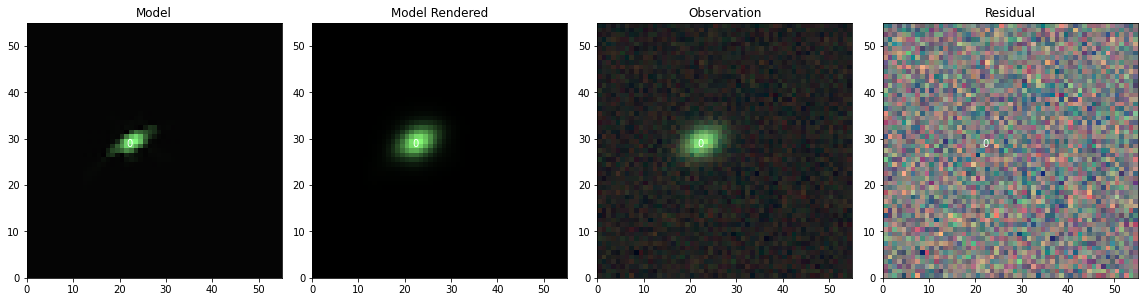

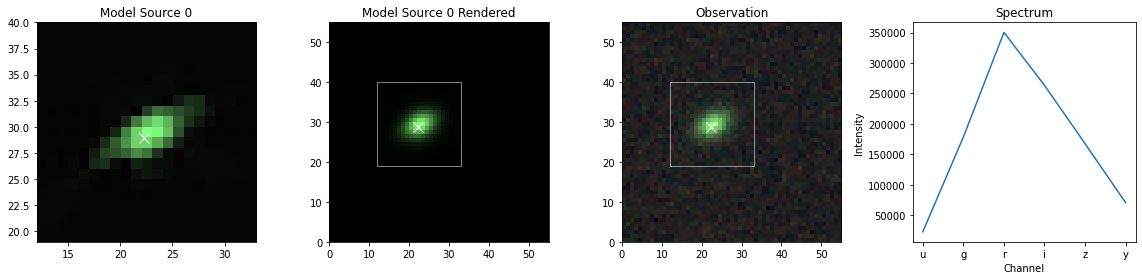

In [10]:
model = predict_with_scarlet(image, x_pos=x_pos, y_pos=y_pos, show_scene=True, show_sources=True, filters=bands)

In [11]:
predictions=[]
for i, image in enumerate(field_images):
    image = field_images[i]
    x_pos = blend['blend_list'][i]['y_peak']
    y_pos = blend['blend_list'][i]['x_peak']
    model = predict_with_scarlet(image, x_pos=x_pos, y_pos=y_pos, show_scene=False, show_sources=False, filters=bands)
    predictions.append(model)

CPU times: user 820 ms, sys: 1.47 ms, total: 822 ms
Wall time: 822 ms
CPU times: user 115 ms, sys: 0 ns, total: 115 ms
Wall time: 115 ms
CPU times: user 352 ms, sys: 1.59 ms, total: 354 ms
Wall time: 353 ms
CPU times: user 701 ms, sys: 6.11 ms, total: 707 ms
Wall time: 707 ms
CPU times: user 462 ms, sys: 0 ns, total: 462 ms
Wall time: 462 ms
CPU times: user 156 ms, sys: 0 ns, total: 156 ms
Wall time: 156 ms
CPU times: user 1 s, sys: 329 µs, total: 1 s
Wall time: 1 s
CPU times: user 161 ms, sys: 153 µs, total: 161 ms
Wall time: 161 ms
CPU times: user 798 ms, sys: 3.62 ms, total: 801 ms
Wall time: 804 ms
CPU times: user 859 ms, sys: 572 µs, total: 860 ms
Wall time: 859 ms


In [19]:
cov = []
for blend_number in range(len(field_images)):
    for galaxy_number in range(len(blend['blend_list'][blend_number])):
        ground_truth_pixels = []
        predicted_pixels = []
        sig = []
        current_galaxy = isolated_images[blend_number][galaxy_number]
        for band_number in range(len(bands)):
            sig.append(sep.Background(field_images[blend_number][band_number]).globalrms)
            #print(np.shape(current_galaxy))
            mask1 = current_galaxy[band_number]>5 * sig[band_number]
            mask2 = predictions[blend_number][band_number]>5 * sig[band_number]
            mask = mask1|mask2
            ground_truth_pixels.extend(current_galaxy[band_number][mask])
            predicted_pixels.extend(predictions[blend_number][band_number][mask])
        cov.append(np.sum(np.multiply(predicted_pixels, ground_truth_pixels))/(np.sqrt(np.sum(np.square(predicted_pixels)))*np.sqrt(np.sum(np.square(ground_truth_pixels)))))

(array([1., 0., 0., 0., 0., 0., 2., 0., 1., 6.]),
 array([0.9917175 , 0.99253916, 0.99336081, 0.99418247, 0.99500413,
        0.99582578, 0.99664744, 0.99746909, 0.99829075, 0.9991124 ,
        0.99993406]),
 <BarContainer object of 10 artists>)

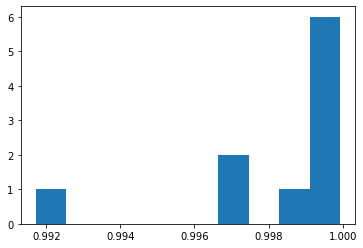

In [13]:
plt.hist(cov)

# Use MADNESS

In [20]:
import sys 
sys.path.insert(0,'../')
from scripts.Deblender import Deblend
import tensorflow as tf
import tensorflow_probability as tfp


madness_predictions = []
for i in range(len(blend['blend_list'])):
    blends = blend['blend_list'][i]
    print(blends)
    detected_positions = []
    for j in range(len(blends)):
        detected_positions.append([blends['y_peak'][j], blends['x_peak'][j]])

    deb = Deblend(field_images[i]/80000, 
                  detected_positions,
                  latent_dim=8, 
                  num_components=len(blends), 
                  use_likelihood=True, 
                  max_iter=300)
    #tf.config.run_functions_eagerly(False)
    convergence_criterion = tfp.optimizer.convergence_criteria.LossNotDecreasing(atol=.00005*45*45*len(blends)*3, min_num_steps=50, window_size=15)
    #convergence_criterion = None
    lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.05, decay_steps=10, decay_rate=0.8, staircase=True)
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_scheduler, momentum=0.1)

    deb(convergence_criterion, optimizer=optimizer, use_deblender=False, compute_sig_dynamically=False)
    madness_predictions.append(deb.get_components())
    del(deb)

IDENT_1          ra                dec         ... not_drawn_z not_drawn_y
------- ------------------- ------------------ ... ----------- -----------
  80168 -0.9511078228044072 0.3800077910208013 ...         0.0         0.0



--- Starting gradient descent in the latent space ---
Maximum number of iterations: 300
Number of Galaxies: 1
Dimensions of latent space: 8


10295.3877
15.3131485
156689.391
-21.1038857
11080.7988
-60.420105
9885.33691
-67.0485535
9720.49609
-63.5008
9601.39844
-60.252079
9492.35938
-56.0018425
9425.30859
-52.304142
9383.21484
-49.0125275
9356.35352
-46.1148
9335.44629
-43.4457855
9319.8623
-41.3410797
9305.1084
-39.3132324
9289.45703
-37.3104935
9271.9209
-35.2008934
9254.35938
-33.1034622
9237.17188
-31.0717049
9219.37695
-29.0634174
9201.45605
-27.0456905
9183.38086
-25.0451794
9165.07
-23.081316
9149.03125
-21.4146576
9132.25684
-19.7576027
9115.84277
-18.1803684
9099.74414
-16.6481266
9082.6748
-15.1444149
9065.1875
-13.5757961
9046.28809
-12.0950089
9027.17188
-10.7944317
9009.2168
-9.65315247
8992.10742
-8.68028641
8978.75488
-8.01126671
8966.37109
-7.44036293
8955.10156
-6.82718468
8944.73
-6.26811218
8934.34473
-5.78885078
8924.30762
-5.48298264
8914.32422
-5.3611927
8904.89355
-5.25405312
8895.00586
-5.11445808
8885.0293
-5.14114761
8878.92871
-5.22234344
8874.32715
-5.2766819
8870.81445
-5.19122505
8868.13574
-5.

--- Gradient descent complete ---

Time taken for gradient descent: 6.100647687911987


IDENT_1          ra                 dec         ... not_drawn_z not_drawn_y
------- -------------------- ------------------ ... ----------- -----------
 569705 -0.06040164684567961 0.3903411092653897 ...         0.0         0.0



--- Starting gradient descent in the latent space ---
Maximum number of iterations: 300
Number of Galaxies: 1
Dimensions of latent space: 8


179896.703
3.18706226
41775.5469
-76.0826
15196.002
-92.8018188
11976.7695
-89.7853
11039.1455
-96.5467148
10519.4834
-103.115799
10168.3477
-108.681007
9917.46289
-113.17009
9741.1416
-115.37384
9611.83398
-116.339455
9513.12695
-116.375938
9450.12305
-115.671555
9398.17
-114.360313
9353.31152
-112.695702
9314.08594
-110.431534
9280.0127
-107.807541
9251.1748
-104.802628
9226.54785
-101.596458
9205.64648
-98.1195068
9187.48242
-94.2793121
9171.44824
-90.1924133
9159.74512
-86.621994
9149.47559
-83.1659851
9139.9043
-79.6853867
9131.06543
-76.1593399
9123.04
-72.6265259
9115.6875
-69.1080093
9108.8916
-65.6962051
9102.66699
-62.2816849
9097.06445
-58.7930412
9091.88379
-55.3752
9087.89941
-52.5215073
9084.1709
-49.7343941
9080.71289
-46.989563
9077.54
-44.3090248
9074.52637
-41.7343826
9071.74902
-39.2072144
9069.18848
-36.6748161
9066.77
-34.1578941
9064.48
-31.6755047
9062.33887
-29.242939
9060.69824
-27.2991257
9059.12
-25.4199257
9057.5
-23.5377769
9055.85254
-21.6777401
9054.19141

--- Gradient descent complete ---

Time taken for gradient descent: 7.681558847427368


IDENT_1          ra                 dec         ... not_drawn_z not_drawn_y
------- ------------------- ------------------- ... ----------- -----------
 993032 -0.9873359895296562 -0.7116336936876613 ...         0.0         0.0



--- Starting gradient descent in the latent space ---
Maximum number of iterations: 300
Number of Galaxies: 1
Dimensions of latent space: 8


9695.71875
12.4137259
82837.3359
-228.282623
9431.98828
-8.88959694
9612.85352
9.53513
9497.84082
-0.330152512
9472.37891
-5.54550743
9453.04785
0.0085144043
9423.63477
-4.04715157
9401.0957
-2.74612236
9376.04199
-3.39554977
9348.42676
-3.68803978
9325.14355
-3.62877083
9302.28711
-5.31689453
9279.15723
-6.98742485
9255.52344
-8.1455307
9217.98828
-6.08089066
9175.70801
-6.00615501
9145.15
-6.12825
9125.62305
-6.58676529
9111.04297
-7.91990471
9097.79883
-9.90361595
9087.29492
-11.8322105
9078.65
-13.7020588
9072.6543
-15.3402386
9068.95312
-15.861412
9066.17676
-15.9766369
9064.08301
-15.6364288
9062.29883
-15.0634842
9060.67773
-14.3318844
9058.94824
-13.6076374
9057.44727
-12.7074356
9056.29199
-11.8965797
9055.35547
-11.0004177
9054.76465
-10.1602879
9056.58
-9.27613068
9073.4248
-8.3151722
9114.66895
-6.43909454
9058.81445
-2.34736824
9053.91504
-2.45260429
9050.81348
-3.10480309
9053.1416
-1.62152863
9050.54395
-1.93005562
9054.00586
0.387237549
9050.96582
-0.506446838
9057.8261

--- Gradient descent complete ---

Time taken for gradient descent: 7.695529937744141


IDENT_1         ra                 dec          ... not_drawn_z not_drawn_y
------- ------------------ -------------------- ... ----------- -----------
 106761 1.0530732487228538 -0.43525145986752334 ...         0.0         0.0



--- Starting gradient descent in the latent space ---
Maximum number of iterations: 300
Number of Galaxies: 1
Dimensions of latent space: 8


27309.2207
18.8041611
90176.2578
-73.9113083
21989.6016
11.5159512
17575.4492
4.98584175
10451.0088
-15.0187626
9613.72
-13.3157272
9236.51562
-4.60174
9140.79
-3.00325012
9091.04785
-2.15631294
9056.80469
-1.42508698
9030.23
-0.954082489
9011.41602
-0.603773117
8996.28516
-0.323753357
8983.96
-0.0714378357
8974.23926
0.172689438
8966.58789
0.431316376
8960.79688
0.673582077
8956.52344
0.918685913
8953.33301
1.1951313
8950.91309
1.48857117
8949.06
1.82249641
8947.81055
2.09099388
8946.75
2.37351799
8945.76758
2.652668
8944.81543
2.95647049
8943.85156
3.26415443
8942.85645
3.57701492
8941.82812
3.90212059
8940.76465
4.2586441
8939.62207
4.56267929
8938.63477
4.99907684
8937.65625
5.12991619
8937.51562
5.69788
8938.10156
5.53769875
8947.5166
6.69554901
8989.95312
5.26028347
9254.83887
9.33636665
10624.166
1.302948
15248.1279
16.5274754
10095.8906
7.15665627
10366.0762
14.1929693
9188.98438
8.33558083
9019.10449
11.2549992
8958.26074
9.32392693
8944.03223
10.793869
8936.70703
9.64884567
8

--- Gradient descent complete ---

Time taken for gradient descent: 6.325443267822266


IDENT_1         ra                dec         ... not_drawn_z not_drawn_y
------- ----------------- ------------------- ... ----------- -----------
 140683 1.064427064918653 0.45118884973764706 ...         0.0         0.0



--- Starting gradient descent in the latent space ---
Maximum number of iterations: 300
Number of Galaxies: 1
Dimensions of latent space: 8


4017845.5
-3.14971066
2075248.5
-1.32047462
1170977.62
-4.49874258
733738.5
-7.88515949
486703.031
-10.704771
339364.719
-12.5751572
249725.844
-13.5697756
188797
-14.3350143
147383.812
-14.6559715
117217.719
-14.9010963
94583.5312
-14.5866604
80015.9922
-14.1108551
69087.7422
-13.6090269
60503.4883
-13.2241592
53733.9102
-12.9432
48177.0859
-12.2889442
43550.6133
-11.9747715
39415.5547
-11.7526817
35749.9492
-11.5318193
32522.7715
-11.3228741
29666.4238
-11.122406
27608.8438
-10.9651537
25796.5352
-10.7009859
24182.6758
-10.5168819
22741.4375
-10.320632
21427.6621
-10.1485109
20205.8945
-9.95383358
19104.1016
-9.81722355
18099.2305
-9.71389198
17201.7344
-9.61755276
16388.9082
-9.5395546
15781.6953
-9.50132656
15237.0117
-9.47859764
14731.459
-9.46056271
14266.4893
-9.43874931
13846.6055
-9.43816471
13469.4873
-9.40873051
13121.1758
-9.41400623
12809.7559
-9.39091873
12539.9385
-9.30382824
12301.3447
-9.29044914
12124.7715
-9.29169273
11965.3174
-9.2936306
11819.3535
-9.31336212
11685

--- Gradient descent complete ---

Time taken for gradient descent: 8.235671281814575


IDENT_1          ra                 dec         ... not_drawn_z not_drawn_y
------- ------------------- ------------------- ... ----------- -----------
  19877 -0.6379257157789342 -0.1663390124240306 ...         0.0         0.0



--- Starting gradient descent in the latent space ---
Maximum number of iterations: 300
Number of Galaxies: 1
Dimensions of latent space: 8


39143.9961
10.2365723
19444.9512
-165.860764
11338.5234
-199.81665
10701.0703
-172.289658
10445.0938
-151.514786
10122.2354
-131.435471
9644.61914
-109.283936
9504.92383
-97.258728
9470.48145
-93.5622253
9437.44824
-90.5068588
9406.3
-86.4192276
9375.64
-82.51297
9341.0918
-77.8819504
9309.6543
-73.4029465
9282.08203
-68.8371506
9260.69727
-64.2971725
9242.97266
-59.5807076
9228.38184
-54.8813477
9215.84668
-50.0857925
9204.79688
-45.641716
9194.22168
-41.1607437
9185.60352
-37.2840118
9177.33203
-33.3368454
9169.48
-29.3312
9161.53613
-25.5312214
9153.16211
-21.5141449
9144.56934
-17.5809898
9136.24902
-13.7021275
9127.93457
-9.74349403
9120.49316
-6.21478653
9114.4
-3.127882
9109.8
-0.786182404
9105.57324
1.36817169
9101.88867
3.31490898
9098.60352
5.19961166
9095.66113
6.89750099
9093.0293
8.44147396
9090.78223
9.81283
9088.80176
11.0862274
9087.07617
12.2300911
9085.57812
13.3173065
9084.61426
14.0985126
9084.45605
14.8446407
9086.87891
15.5187788
9100.17578
16.1044044
9166.86328
1

--- Gradient descent complete ---

Time taken for gradient descent: 6.495847702026367


IDENT_1          ra                  dec         ... not_drawn_z not_drawn_y
------- -------------------- ------------------- ... ----------- -----------
 161377 -0.47331438255402924 -0.4351007352092223 ...         0.0         0.0



--- Starting gradient descent in the latent space ---
Maximum number of iterations: 300
Number of Galaxies: 1
Dimensions of latent space: 8


75458.8672
21.0108452
43156.4648
-99.878006
57968.8828
15.8719597
13821.0098
3.3453846
22658.2383
-7.24616432
30699.7793
14.3208809
11554.4746
3.34705544
11592.7812
9.06231308
11544.002
4.16120052
13692.2695
10.7502804
12700.9414
4.82313156
12279.1797
11.0902138
9759.28711
7.65428925
9758.30273
10.499773
9752.85156
7.88862514
10345.2441
11.3085537
10819.6367
7.66311
12432.8662
12.5479698
11203.5176
8.70876884
12861.3203
13.1640472
11470.0898
9.3618269
10792.2314
12.8591824
9266.68
11.04107
9177.81934
12.3856373
9153.69434
11.2889709
9269.8457
12.6468163
9370.03516
11.2021313
9828.60938
13.1728
10185.1943
10.8953638
11571.3398
13.8820887
11188.9941
10.9336681
10544.3926
13.6933107
9178.47
12.175024
9030.99902
13.0960026
8988.14648
12.4113379
9004.05371
13.1050949
9036.15
12.4091921
9154.27734
13.2618361
9323.61
12.2122173
9946.38281
13.6679783
10421.5752
11.7218332
10278.5449
13.7541828
9169.89648
12.579
9053.56055
13.3489304
8974.50293
12.7731638
8976.50488
13.2702341
8978.64062
12.785

--- Gradient descent complete ---

Time taken for gradient descent: 6.845148324966431


IDENT_1         ra                dec         ... not_drawn_z not_drawn_y
------- ------------------ ------------------ ... ----------- -----------
 105372 -1.057497957058063 0.7534322901076422 ...         0.0         0.0



--- Starting gradient descent in the latent space ---
Maximum number of iterations: 300
Number of Galaxies: 1
Dimensions of latent space: 8


15461.249
19.1429863
107620.523
-115.830444
13953.6504
14.5790443
14472.3574
18.3267841
13637.498
16.4568138
12603.166
13.8390007
11431.0107
10.8321333
10738.3682
7.95324135
10251.6924
4.12872314
9671.64648
-4.53487396
9285.36914
-18.6831684
9184.49707
-24.5333214
9127.3877
-24.9645863
9085.83789
-24.5945816
9054.38184
-24.4428368
9029.46875
-24.1596813
9010.67383
-24.0178757
8998.80371
-23.4250755
8990.71582
-23.0892029
8985.39
-22.5780525
8981.58
-21.9785728
8979.25293
-21.4205952
8977.40625
-20.8552227
8975.88184
-20.2867508
8974.66
-19.6816368
8973.60352
-19.0827217
8972.68164
-18.4728813
8971.92773
-17.7855434
8971.22266
-17.0601559
8970.51855
-16.296524
8969.79688
-15.5163212
8969.23438
-14.7757111
8968.60254
-14.0291138
8968.0127
-13.1969471
8967.36621
-12.3892059
8966.86328
-11.4471684
8966.26
-10.5924
8965.65
-9.73239326
8964.9043
-8.92682648
8964.27832
-7.9482708
8963.46387
-7.21821594
8963.41602
-6.1355648
8963.0459
-6.05086136
8967.37109
-4.11538696
8979.99902
-5.45448494
9

--- Gradient descent complete ---

Time taken for gradient descent: 7.00981879234314


IDENT_1         ra                dec         ... not_drawn_z not_drawn_y
------- ------------------ ------------------ ... ----------- -----------
 200310 0.0387242629820137 0.2978946647787597 ...         0.0         0.0



--- Starting gradient descent in the latent space ---
Maximum number of iterations: 300
Number of Galaxies: 1
Dimensions of latent space: 8


58066.8125
8.62317657
22084.4043
-64.771019
18591.1738
-59.4884033
15458.4443
-23.5597019
14850.1641
-10.9247131
14638.5508
-6.50639153
14508.6523
-4.57474899
14411.4395
-3.63704681
14324.7373
-3.39848137
14240.5293
-3.46704865
14142.1729
-3.71859741
14049.8926
-3.91738319
13940.5156
-4.18390465
13818.2295
-4.18576431
13678.3477
-4.31676197
13484.7832
-4.26716518
13210.1426
-5.10118771
12785.585
-5.53607941
12051.1338
-3.86444569
10812.4131
-1.14271927
9662.37
0.366235733
9221.33789
1.4191761
9015.85547
1.91051865
8921.40527
2.15614223
8873.16699
1.9924221
8847.49
2.03153801
8860.72656
1.32492924
9036.25
1.90675163
9835.33
-0.355162621
13214.0596
-1.61990356
10784.8477
1.02083302
9813.90234
-0.593585968
8919.76367
-1.0036478
8837.83
-0.668084145
8805.48633
-1.1747694
8789.08496
-1.39539909
8775.18848
-1.77866364
8763.9
-2.05509377
8754.6084
-2.44111443
8747.76074
-2.65509033
8743.68555
-3.09345245
8740.75684
-3.07161331
8738.89746
-3.56948853
8742.34
-3.36904335
8758.12793
-4.1072464
8

--- Gradient descent complete ---

Time taken for gradient descent: 6.028473854064941


IDENT_1          ra                dec         ... not_drawn_z not_drawn_y
------- ------------------- ------------------ ... ----------- -----------
 145691 0.20971225115633696 0.3546521723027187 ...         0.0         0.0



--- Starting gradient descent in the latent space ---
Maximum number of iterations: 300
Number of Galaxies: 1
Dimensions of latent space: 8


71765.3672
10.972333
81593.2656
-6.81545734
27815.6621
8.56742096
11036.918
4.48283768
9627.27344
6.11297321
9225.6709
6.657444
9017.125
6.51443481
8900.46191
6.63985729
8837.18359
6.54376793
8802.05273
6.73604679
8780.99414
6.67128658
8765.37695
6.86915302
8754.95312
6.80663109
8747.59
7.01133156
8743.12891
6.93753862
8745.29688
7.22850847
8764.46094
6.98224354
8844.86523
7.57231569
9144.50879
6.73274946
10264.3486
8.36459923
14108.3887
5.24803352
14977.1855
9.19988632
12111.8242
5.57417202
11028.124
8.56278896
9923.29395
6.56251431
9750.43359
8.28185272
9655.13574
6.81568146
9888.81836
8.44666481
10140.5332
6.77672911
10841.7031
8.68848324
11509.1934
6.42307091
10016.9336
8.45964
9165.51367
7.21133518
8961.91797
8.15606
8850.35742
7.49949741
8844.97461
8.09008789
8850.2627
7.52196455
8930.20898
8.16806
9071.99414
7.39685774
9494.79
8.42723465
10244.5713
6.99063969
9994.64258
8.5595932
9449.4873
7.29319334
9259.49609
8.34888
9084.38672
7.47266817
9074.18262
8.28026772
9059.57129
7.505

--- Gradient descent complete ---

Time taken for gradient descent: 6.166344404220581


In [21]:
np.shape(madness_predictions[0])

(1, 6, 45, 45)

In [22]:
import sys 
sys.path.insert(0,'../')
from scripts.extraction import extract_cutouts

IDENT_1          ra                dec         ... not_drawn_z not_drawn_y
------- ------------------- ------------------ ... ----------- -----------
 145691 0.20971225115633696 0.3546521723027187 ...         0.0         0.0
[0]
(45, 45, 6)


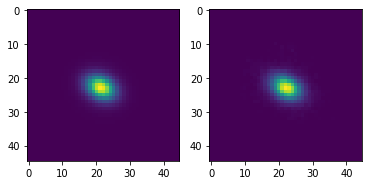

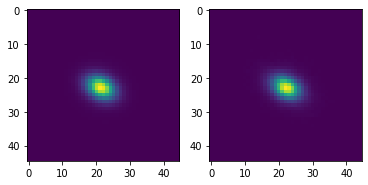

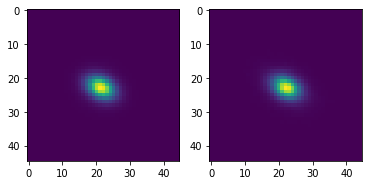

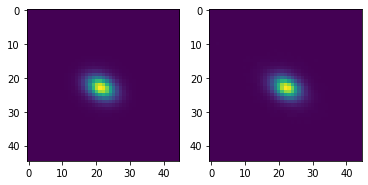

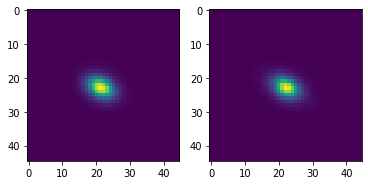

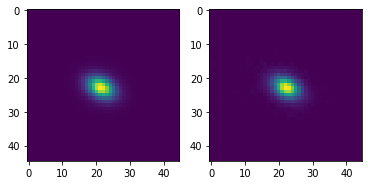

IDENT_1          ra                dec         ... not_drawn_z not_drawn_y
------- ------------------- ------------------ ... ----------- -----------
 145691 0.20971225115633696 0.3546521723027187 ...         0.0         0.0
[0]
(45, 45, 6)


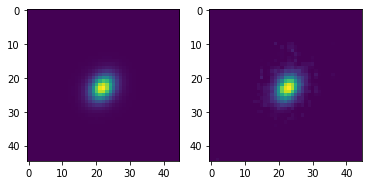

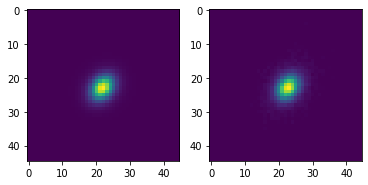

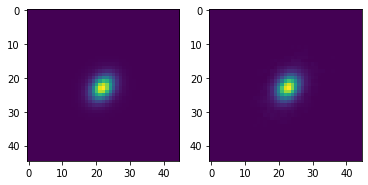

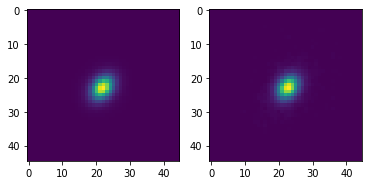

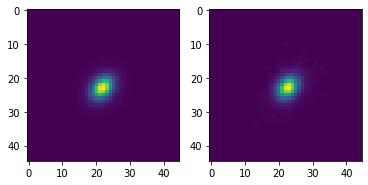

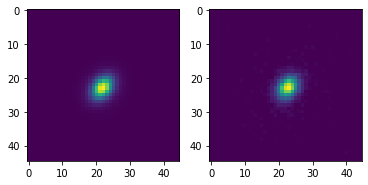

IDENT_1          ra                dec         ... not_drawn_z not_drawn_y
------- ------------------- ------------------ ... ----------- -----------
 145691 0.20971225115633696 0.3546521723027187 ...         0.0         0.0
[0]
(45, 45, 6)


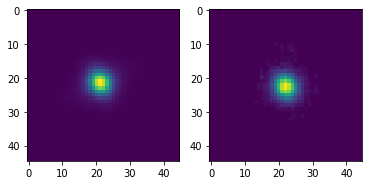

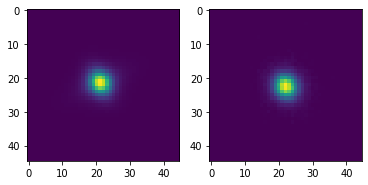

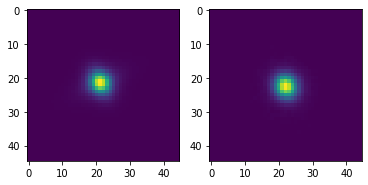

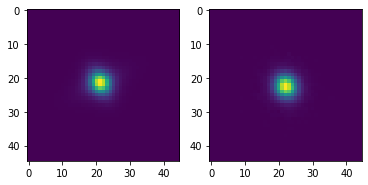

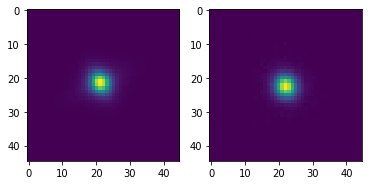

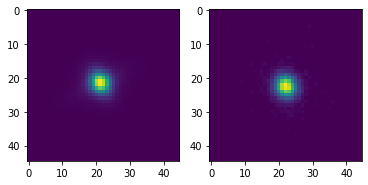

IDENT_1          ra                dec         ... not_drawn_z not_drawn_y
------- ------------------- ------------------ ... ----------- -----------
 145691 0.20971225115633696 0.3546521723027187 ...         0.0         0.0
[0]
(45, 45, 6)


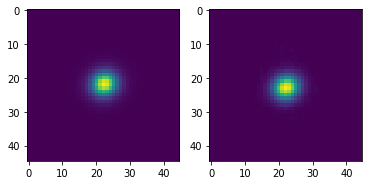

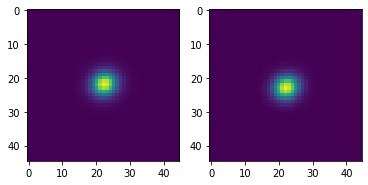

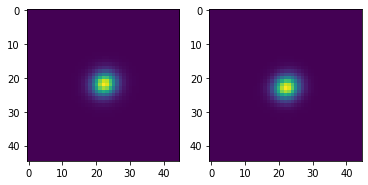

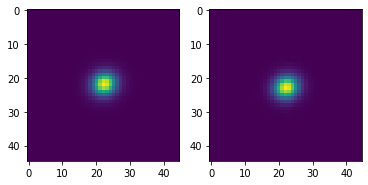

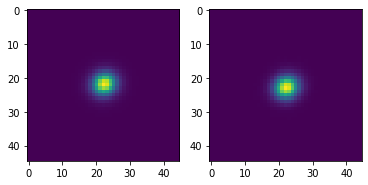

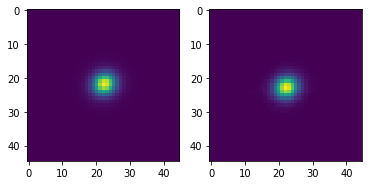

IDENT_1          ra                dec         ... not_drawn_z not_drawn_y
------- ------------------- ------------------ ... ----------- -----------
 145691 0.20971225115633696 0.3546521723027187 ...         0.0         0.0
[0]
(45, 45, 6)


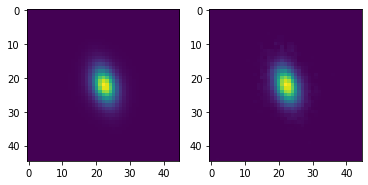

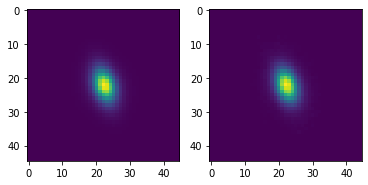

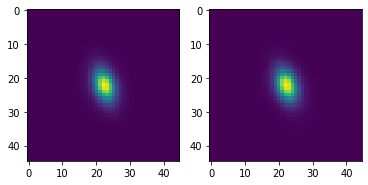

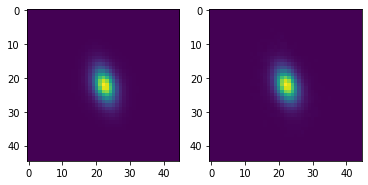

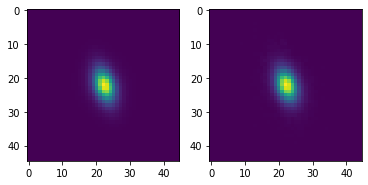

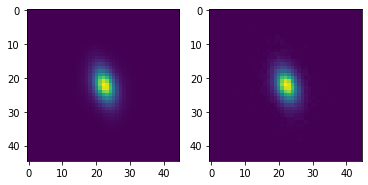

IDENT_1          ra                dec         ... not_drawn_z not_drawn_y
------- ------------------- ------------------ ... ----------- -----------
 145691 0.20971225115633696 0.3546521723027187 ...         0.0         0.0
[0]
(45, 45, 6)


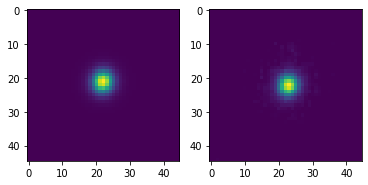

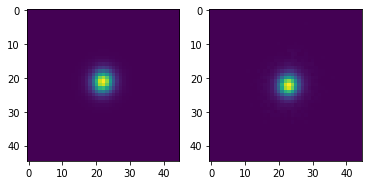

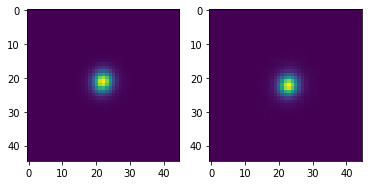

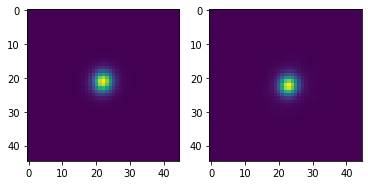

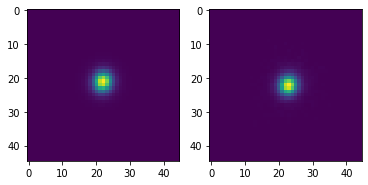

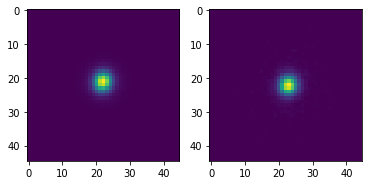

IDENT_1          ra                dec         ... not_drawn_z not_drawn_y
------- ------------------- ------------------ ... ----------- -----------
 145691 0.20971225115633696 0.3546521723027187 ...         0.0         0.0
[0]
(45, 45, 6)


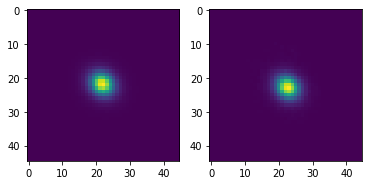

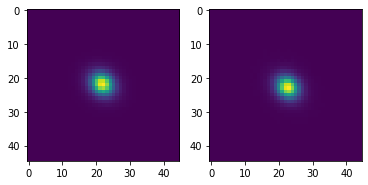

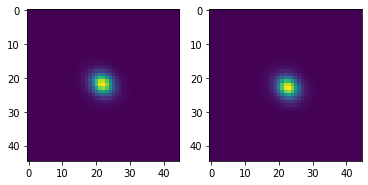

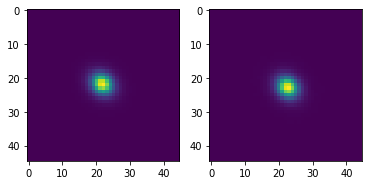

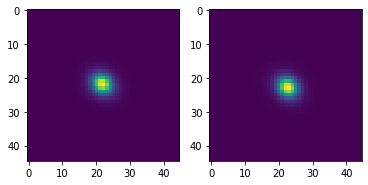

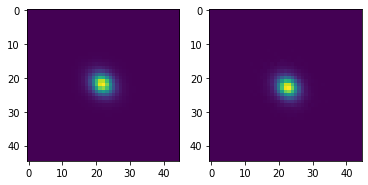

IDENT_1          ra                dec         ... not_drawn_z not_drawn_y
------- ------------------- ------------------ ... ----------- -----------
 145691 0.20971225115633696 0.3546521723027187 ...         0.0         0.0
[0]
(45, 45, 6)


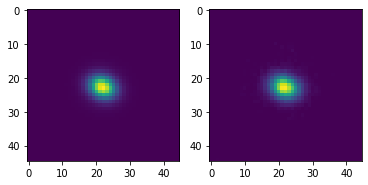

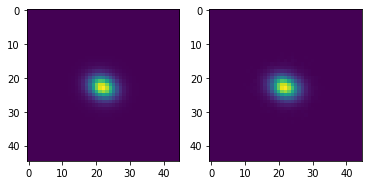

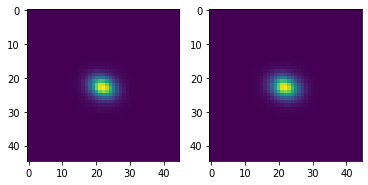

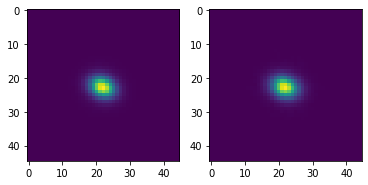

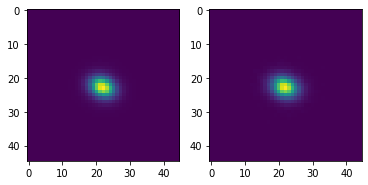

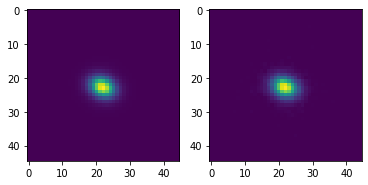

IDENT_1          ra                dec         ... not_drawn_z not_drawn_y
------- ------------------- ------------------ ... ----------- -----------
 145691 0.20971225115633696 0.3546521723027187 ...         0.0         0.0
[0]
(45, 45, 6)


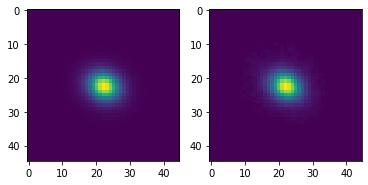

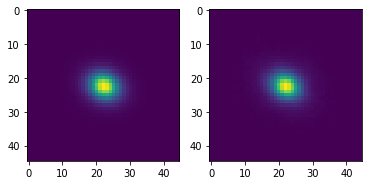

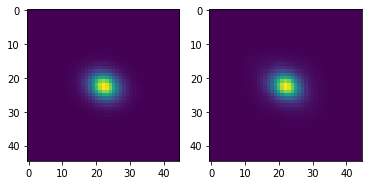

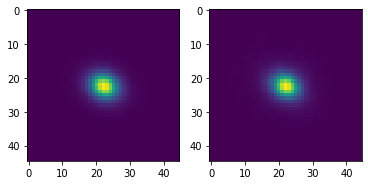

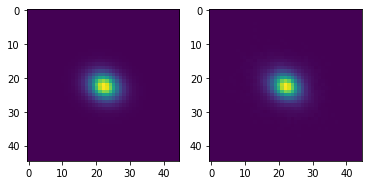

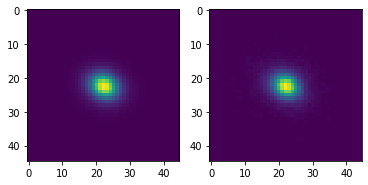

IDENT_1          ra                dec         ... not_drawn_z not_drawn_y
------- ------------------- ------------------ ... ----------- -----------
 145691 0.20971225115633696 0.3546521723027187 ...         0.0         0.0
[0]
(45, 45, 6)


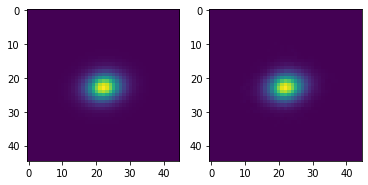

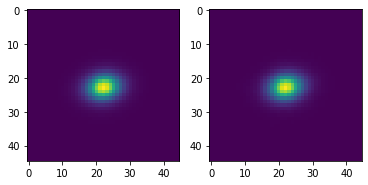

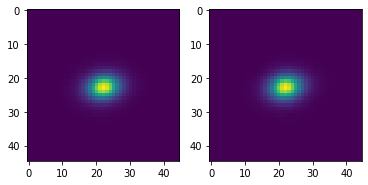

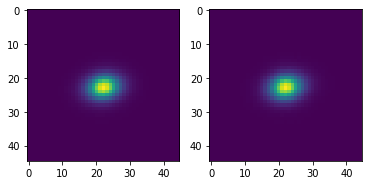

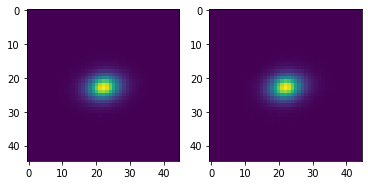

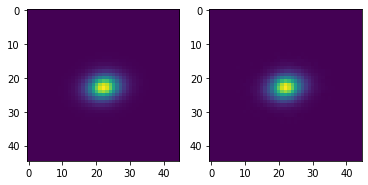

In [23]:
cov_madness = []
for blend_number in range(len(field_images)):
    blends_meta_data = blend['blend_list'][blend_number]
    print(blends)
    
    for galaxy_number in range(len(blends_meta_data)):
        detected_position = [[blends_meta_data['y_peak'][galaxy_number], blends_meta_data['x_peak'][galaxy_number]]]
        distances_to_center = list(
            np.array(detected_position) - int((np.shape(field_images[0])[1] - 1) / 2)
        )
        cutout_galaxy, idx = extract_cutouts(isolated_images[blend_number][galaxy_number], distances_to_center, cutout_size=45)
        print(idx)
        if idx == [] :
            continue
        cutout_galaxy = cutout_galaxy[0]
        #cutout_galaxy = np.transpose(cutout_galaxy, axes=(1, 2, 0))
        print(np.shape(cutout_galaxy))
        ground_truth_pixels = []
        predicted_pixels = []
        sig = []

        for band_number in range(len(bands)):
            sig.append(sep.Background(isolated_images[blend_number][galaxy_number][band_number]).globalrms)
            mask1 = cutout_galaxy[:, :, band_number]>5 * sig[band_number]
            mask2 = madness_predictions[blend_number][galaxy_number][band_number]>5 * sig[band_number]
            mask = mask1|mask2
            fig, ax = plt.subplots(1, 2)
            plt.subplot(1,2,1)
            plt.imshow(cutout_galaxy[:, :, band_number])
            plt.subplot(1, 2, 2)
            plt.imshow(madness_predictions[blend_number][galaxy_number][band_number])
            ground_truth_pixels.extend(cutout_galaxy[:, :, band_number][mask])
            predicted_pixels.extend(madness_predictions[blend_number][galaxy_number][band_number][mask])
            plt.show()

        cov_madness.append(np.sum(np.multiply(predicted_pixels, ground_truth_pixels))/(np.sqrt(np.sum(np.square(predicted_pixels)))*np.sqrt(np.sum(np.square(ground_truth_pixels)))))

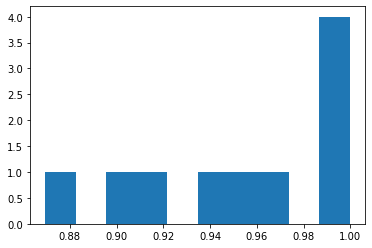

In [24]:
plt.hist(cov_madness);